In [284]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# LOAD MNIST dataset from tensorflow package

In [285]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [286]:
tf.reset_default_graph()

batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

dec_in_channels = 1
n_latent = 8

reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 48 * dec_in_channels / 2

def leaky_relu(x, alpha=0.3):
    return tf.maximum(x, tf.multiply(x, alpha))

In [287]:
# VAE Class with CNN implementation for encoder and decoder
# inspired by https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

def encoder(X_in, keep_prob):
    activation = leaky_relu
    with tf.variable_scope("encoder", reuse=None):
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1])
        x = tf.layers.conv2d(X, filters=32, kernel_size=3, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=2, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d(x, filters=32, kernel_size=3, strides=1, padding='same', activation=activation)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.contrib.layers.flatten(x)
        mn = tf.layers.dense(x, units=n_latent)
        sd = 0.5 * tf.layers.dense(x, units=n_latent)            
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent])) 
        z  = mn + tf.multiply(epsilon, tf.exp(sd))
        
        return z, mn, sd

def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=leaky_relu)
        x = tf.layers.dense(x, units=inputs_decoder * 2 + 1, activation=leaky_relu)
        x = tf.reshape(x, reshaped_dim)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=3, strides=1, padding='same', activation=tf.nn.relu)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        img = tf.reshape(x, shape=[-1, 28, 28])
        return img

In [288]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

unreshaped = tf.reshape(dec, [-1, 28*28])
# image reconstruction loss
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
# KL divergence loss
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(0.0005).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Save model every 10,000 steps
saver = tf.train.Saver()
saver.save(sess, './vae_mnist_model', global_step=10000, write_meta_graph=False)
# Create a write to record data for tensorboard visualization
writer = tf.summary.FileWriter('./vae_mnist_tensorboard', sess.graph)

iteration: 0, overall_loss: 178.4798583984375, recon_loss: 178.47000122070312, kl_loss: 0.009867310523986816


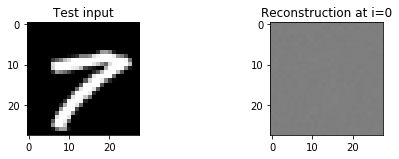

iteration: 100, overall_loss: 53.80332946777344, recon_loss: 53.62799835205078, kl_loss: 0.1753329336643219
iteration: 200, overall_loss: 48.638282775878906, recon_loss: 47.825042724609375, kl_loss: 0.8132425546646118
iteration: 300, overall_loss: 46.58475112915039, recon_loss: 44.22747039794922, kl_loss: 2.3572804927825928
iteration: 400, overall_loss: 42.13001251220703, recon_loss: 36.755287170410156, kl_loss: 5.37472677230835
iteration: 500, overall_loss: 40.913299560546875, recon_loss: 35.37481689453125, kl_loss: 5.538481712341309


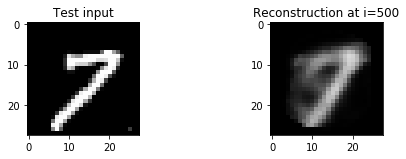

iteration: 600, overall_loss: 36.929595947265625, recon_loss: 30.507022857666016, kl_loss: 6.42257022857666
iteration: 700, overall_loss: 37.75741195678711, recon_loss: 30.7236385345459, kl_loss: 7.03377103805542
iteration: 800, overall_loss: 36.89801788330078, recon_loss: 29.661577224731445, kl_loss: 7.236441612243652
iteration: 900, overall_loss: 35.793582916259766, recon_loss: 27.892915725708008, kl_loss: 7.900667667388916
iteration: 1000, overall_loss: 32.33021545410156, recon_loss: 24.59491539001465, kl_loss: 7.735301971435547


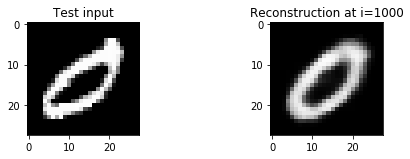

iteration: 1100, overall_loss: 33.51314926147461, recon_loss: 25.895158767700195, kl_loss: 7.617990493774414
iteration: 1200, overall_loss: 36.68888854980469, recon_loss: 28.990957260131836, kl_loss: 7.697930335998535
iteration: 1300, overall_loss: 34.357948303222656, recon_loss: 26.721221923828125, kl_loss: 7.6367268562316895
iteration: 1400, overall_loss: 33.79222106933594, recon_loss: 25.382278442382812, kl_loss: 8.409942626953125
iteration: 1500, overall_loss: 35.00651168823242, recon_loss: 26.339210510253906, kl_loss: 8.667299270629883


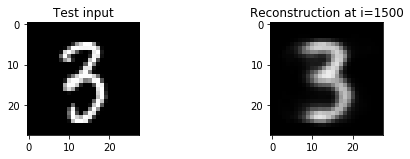

iteration: 1600, overall_loss: 32.664947509765625, recon_loss: 24.422353744506836, kl_loss: 8.242593765258789
iteration: 1700, overall_loss: 32.54434585571289, recon_loss: 24.34450340270996, kl_loss: 8.19984245300293
iteration: 1800, overall_loss: 33.44388961791992, recon_loss: 24.972434997558594, kl_loss: 8.471452713012695
iteration: 1900, overall_loss: 33.9011116027832, recon_loss: 25.272151947021484, kl_loss: 8.628959655761719
iteration: 2000, overall_loss: 32.557960510253906, recon_loss: 24.651721954345703, kl_loss: 7.906239032745361


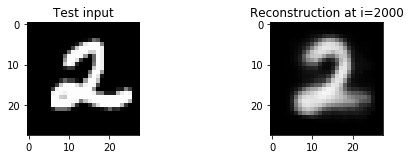

iteration: 2100, overall_loss: 32.997276306152344, recon_loss: 24.67593002319336, kl_loss: 8.321346282958984
iteration: 2200, overall_loss: 33.08911895751953, recon_loss: 23.84765625, kl_loss: 9.241458892822266
iteration: 2300, overall_loss: 36.028968811035156, recon_loss: 27.562557220458984, kl_loss: 8.466415405273438
iteration: 2400, overall_loss: 35.430912017822266, recon_loss: 26.27463150024414, kl_loss: 9.156279563903809
iteration: 2500, overall_loss: 31.648351669311523, recon_loss: 23.459131240844727, kl_loss: 8.189220428466797


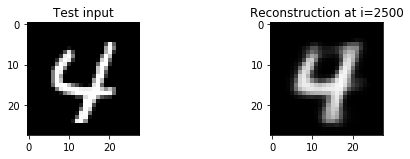

iteration: 2600, overall_loss: 31.399200439453125, recon_loss: 22.557289123535156, kl_loss: 8.84190845489502
iteration: 2700, overall_loss: 31.223575592041016, recon_loss: 22.978961944580078, kl_loss: 8.244612693786621
iteration: 2800, overall_loss: 32.38693618774414, recon_loss: 23.87120246887207, kl_loss: 8.515734672546387
iteration: 2900, overall_loss: 30.872007369995117, recon_loss: 21.704750061035156, kl_loss: 9.167257308959961
iteration: 3000, overall_loss: 30.287899017333984, recon_loss: 21.127201080322266, kl_loss: 9.160696983337402


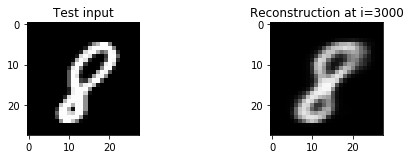

iteration: 3100, overall_loss: 29.19809913635254, recon_loss: 19.860490798950195, kl_loss: 9.337608337402344
iteration: 3200, overall_loss: 33.247589111328125, recon_loss: 24.495777130126953, kl_loss: 8.751809120178223
iteration: 3300, overall_loss: 30.863780975341797, recon_loss: 21.801177978515625, kl_loss: 9.062602996826172
iteration: 3400, overall_loss: 31.250120162963867, recon_loss: 21.975788116455078, kl_loss: 9.274334907531738
iteration: 3500, overall_loss: 31.774944305419922, recon_loss: 22.570178985595703, kl_loss: 9.204763412475586


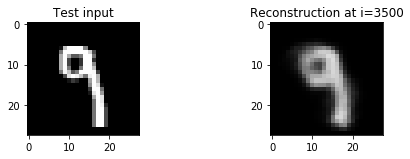

iteration: 3600, overall_loss: 33.25984191894531, recon_loss: 24.010456085205078, kl_loss: 9.249383926391602
iteration: 3700, overall_loss: 33.552127838134766, recon_loss: 24.390743255615234, kl_loss: 9.161385536193848
iteration: 3800, overall_loss: 32.04280090332031, recon_loss: 23.160802841186523, kl_loss: 8.881998062133789
iteration: 3900, overall_loss: 31.944459915161133, recon_loss: 22.903667449951172, kl_loss: 9.040793418884277
iteration: 4000, overall_loss: 30.677608489990234, recon_loss: 21.917526245117188, kl_loss: 8.760082244873047


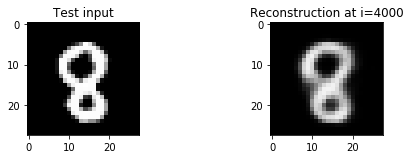

iteration: 4100, overall_loss: 31.064434051513672, recon_loss: 21.98686408996582, kl_loss: 9.077569961547852
iteration: 4200, overall_loss: 31.917648315429688, recon_loss: 22.67485809326172, kl_loss: 9.242788314819336
iteration: 4300, overall_loss: 29.990699768066406, recon_loss: 20.484275817871094, kl_loss: 9.50642204284668
iteration: 4400, overall_loss: 31.758941650390625, recon_loss: 22.51703453063965, kl_loss: 9.241909980773926
iteration: 4500, overall_loss: 30.780590057373047, recon_loss: 21.42945671081543, kl_loss: 9.35113525390625


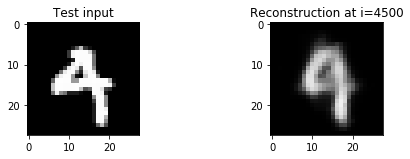

iteration: 4600, overall_loss: 32.13163375854492, recon_loss: 22.59147834777832, kl_loss: 9.540153503417969
iteration: 4700, overall_loss: 29.26358985900879, recon_loss: 19.261478424072266, kl_loss: 10.002111434936523
iteration: 4800, overall_loss: 29.70274543762207, recon_loss: 20.54033660888672, kl_loss: 9.162406921386719
iteration: 4900, overall_loss: 31.85215950012207, recon_loss: 22.619178771972656, kl_loss: 9.232982635498047
iteration: 5000, overall_loss: 31.377235412597656, recon_loss: 21.76213836669922, kl_loss: 9.615097045898438


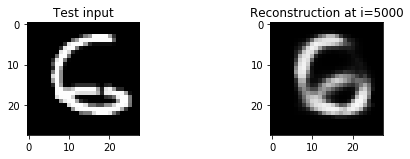

iteration: 5100, overall_loss: 30.216222763061523, recon_loss: 21.288753509521484, kl_loss: 8.927469253540039
iteration: 5200, overall_loss: 31.3992919921875, recon_loss: 21.50841522216797, kl_loss: 9.890875816345215
iteration: 5300, overall_loss: 30.966506958007812, recon_loss: 21.285480499267578, kl_loss: 9.681024551391602
iteration: 5400, overall_loss: 30.145069122314453, recon_loss: 20.993432998657227, kl_loss: 9.151636123657227
iteration: 5500, overall_loss: 28.998859405517578, recon_loss: 19.290191650390625, kl_loss: 9.708667755126953


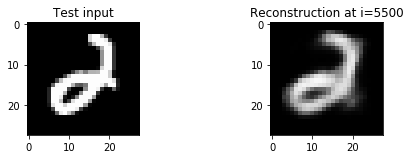

iteration: 5600, overall_loss: 30.386199951171875, recon_loss: 20.994457244873047, kl_loss: 9.391745567321777
iteration: 5700, overall_loss: 31.361141204833984, recon_loss: 21.796871185302734, kl_loss: 9.564270973205566
iteration: 5800, overall_loss: 30.90775489807129, recon_loss: 21.842361450195312, kl_loss: 9.06539249420166
iteration: 5900, overall_loss: 30.311805725097656, recon_loss: 21.073455810546875, kl_loss: 9.238348960876465
iteration: 6000, overall_loss: 30.13434600830078, recon_loss: 20.624515533447266, kl_loss: 9.509828567504883


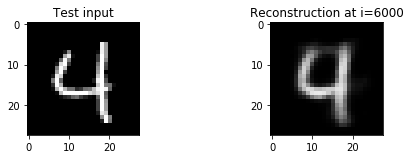

iteration: 6100, overall_loss: 30.29669189453125, recon_loss: 20.763235092163086, kl_loss: 9.533454895019531
iteration: 6200, overall_loss: 30.475730895996094, recon_loss: 20.56020164489746, kl_loss: 9.915529251098633
iteration: 6300, overall_loss: 29.548934936523438, recon_loss: 20.48583221435547, kl_loss: 9.063104629516602
iteration: 6400, overall_loss: 28.750789642333984, recon_loss: 18.92828369140625, kl_loss: 9.822504043579102
iteration: 6500, overall_loss: 29.647079467773438, recon_loss: 20.069904327392578, kl_loss: 9.57717514038086


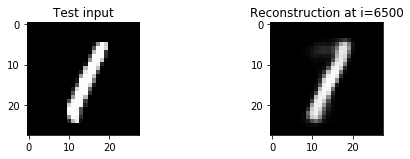

iteration: 6600, overall_loss: 31.980405807495117, recon_loss: 22.466014862060547, kl_loss: 9.51439094543457
iteration: 6700, overall_loss: 30.924297332763672, recon_loss: 21.01285171508789, kl_loss: 9.911444664001465
iteration: 6800, overall_loss: 30.516387939453125, recon_loss: 20.862932205200195, kl_loss: 9.653458595275879
iteration: 6900, overall_loss: 30.846797943115234, recon_loss: 21.150785446166992, kl_loss: 9.696012496948242
iteration: 7000, overall_loss: 28.119264602661133, recon_loss: 18.889606475830078, kl_loss: 9.229658126831055


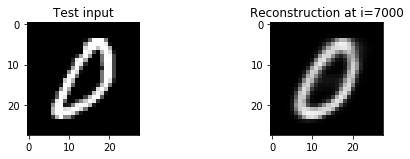

iteration: 7100, overall_loss: 28.816923141479492, recon_loss: 19.218395233154297, kl_loss: 9.598527908325195
iteration: 7200, overall_loss: 27.721038818359375, recon_loss: 18.43869400024414, kl_loss: 9.282344818115234
iteration: 7300, overall_loss: 30.125350952148438, recon_loss: 20.269250869750977, kl_loss: 9.856100082397461
iteration: 7400, overall_loss: 30.464340209960938, recon_loss: 20.309982299804688, kl_loss: 10.154356002807617
iteration: 7500, overall_loss: 27.974815368652344, recon_loss: 18.211559295654297, kl_loss: 9.76325511932373


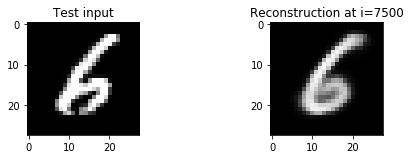

iteration: 7600, overall_loss: 30.270641326904297, recon_loss: 20.622238159179688, kl_loss: 9.64840316772461
iteration: 7700, overall_loss: 29.233509063720703, recon_loss: 19.27045249938965, kl_loss: 9.963057518005371
iteration: 7800, overall_loss: 31.257762908935547, recon_loss: 21.227275848388672, kl_loss: 10.030487060546875
iteration: 7900, overall_loss: 29.100841522216797, recon_loss: 19.16878318786621, kl_loss: 9.932058334350586
iteration: 8000, overall_loss: 30.387882232666016, recon_loss: 20.81356430053711, kl_loss: 9.574318885803223


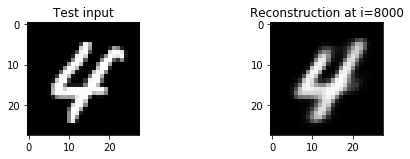

iteration: 8100, overall_loss: 30.673294067382812, recon_loss: 21.160778045654297, kl_loss: 9.512516021728516
iteration: 8200, overall_loss: 28.366857528686523, recon_loss: 19.186264038085938, kl_loss: 9.180593490600586
iteration: 8300, overall_loss: 31.246784210205078, recon_loss: 21.53206443786621, kl_loss: 9.714717864990234
iteration: 8400, overall_loss: 28.857463836669922, recon_loss: 19.537567138671875, kl_loss: 9.319893836975098
iteration: 8500, overall_loss: 30.88361930847168, recon_loss: 20.989280700683594, kl_loss: 9.89433765411377


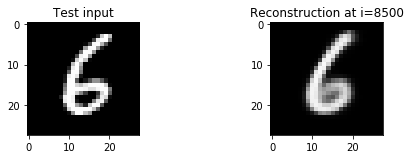

iteration: 8600, overall_loss: 29.454010009765625, recon_loss: 19.72370147705078, kl_loss: 9.730308532714844
iteration: 8700, overall_loss: 29.701457977294922, recon_loss: 19.580825805664062, kl_loss: 10.120635032653809
iteration: 8800, overall_loss: 28.301109313964844, recon_loss: 18.51970672607422, kl_loss: 9.781403541564941
iteration: 8900, overall_loss: 28.811614990234375, recon_loss: 19.10323715209961, kl_loss: 9.708378791809082
iteration: 9000, overall_loss: 28.40224266052246, recon_loss: 18.276172637939453, kl_loss: 10.126069068908691


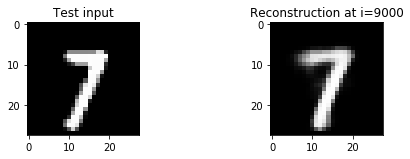

iteration: 9100, overall_loss: 29.24540138244629, recon_loss: 20.180686950683594, kl_loss: 9.064712524414062
iteration: 9200, overall_loss: 29.136201858520508, recon_loss: 19.244354248046875, kl_loss: 9.891845703125
iteration: 9300, overall_loss: 28.875635147094727, recon_loss: 19.05698585510254, kl_loss: 9.818649291992188
iteration: 9400, overall_loss: 29.04286766052246, recon_loss: 19.947511672973633, kl_loss: 9.095355987548828
iteration: 9500, overall_loss: 28.683975219726562, recon_loss: 18.576684951782227, kl_loss: 10.107288360595703


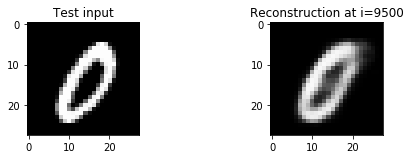

iteration: 9600, overall_loss: 30.146255493164062, recon_loss: 20.528663635253906, kl_loss: 9.617594718933105
iteration: 9700, overall_loss: 32.45336151123047, recon_loss: 22.918495178222656, kl_loss: 9.53486442565918
iteration: 9800, overall_loss: 28.52583122253418, recon_loss: 19.090877532958984, kl_loss: 9.434953689575195
iteration: 9900, overall_loss: 28.72390365600586, recon_loss: 18.459928512573242, kl_loss: 10.263973236083984
iteration: 10000, overall_loss: 29.633953094482422, recon_loss: 19.444358825683594, kl_loss: 10.189594268798828


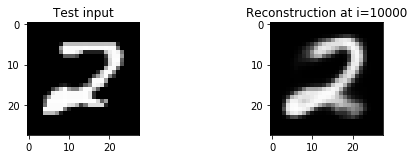

iteration: 10100, overall_loss: 29.29178237915039, recon_loss: 19.25680923461914, kl_loss: 10.034971237182617
iteration: 10200, overall_loss: 28.860645294189453, recon_loss: 18.956392288208008, kl_loss: 9.904252052307129
iteration: 10300, overall_loss: 30.76288604736328, recon_loss: 20.852216720581055, kl_loss: 9.91066837310791
iteration: 10400, overall_loss: 31.392311096191406, recon_loss: 21.010982513427734, kl_loss: 10.381330490112305
iteration: 10500, overall_loss: 28.683277130126953, recon_loss: 18.583709716796875, kl_loss: 10.099569320678711


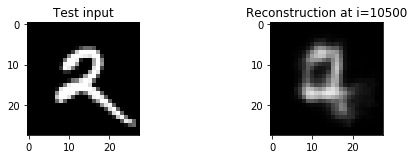

iteration: 10600, overall_loss: 31.680389404296875, recon_loss: 21.367816925048828, kl_loss: 10.312572479248047
iteration: 10700, overall_loss: 27.58255386352539, recon_loss: 18.127342224121094, kl_loss: 9.455211639404297
iteration: 10800, overall_loss: 31.171829223632812, recon_loss: 21.019908905029297, kl_loss: 10.151921272277832
iteration: 10900, overall_loss: 30.650218963623047, recon_loss: 20.61709213256836, kl_loss: 10.033126831054688
iteration: 11000, overall_loss: 29.969383239746094, recon_loss: 19.74544906616211, kl_loss: 10.223931312561035


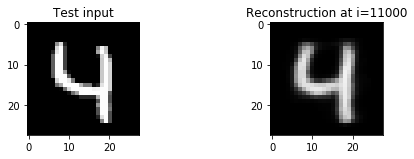

iteration: 11100, overall_loss: 29.59913444519043, recon_loss: 19.86835479736328, kl_loss: 9.730777740478516
iteration: 11200, overall_loss: 31.390125274658203, recon_loss: 21.50057601928711, kl_loss: 9.889549255371094


In [ ]:
for i in range(30000):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
    
    if not i % 100:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        print("iteration: {}, overall_loss: {}, recon_loss: {}, kl_loss: {}".format(
            i, ls, np.mean(i_ls), np.mean(d_ls)))
    if not i % 500:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.figure(figsize=(8, 12))
        plt.subplot(5, 2, 2 + 1)
        plt.imshow(np.reshape(batch[0], [28, 28]), vmin=0, vmax=1, cmap="gray")
        plt.title("Test input")
        plt.subplot(5, 2, 2 + 2)
        plt.imshow(d[0], vmin=0, vmax=1, cmap="gray")
        plt.title("Reconstruction at i={}".format(i))
        plt.show()

write.close()

# Randomly generate some images from normal distribution

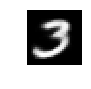

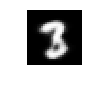

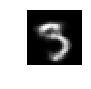

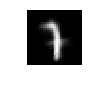

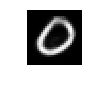

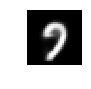

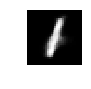

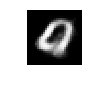

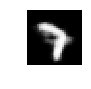

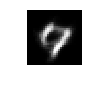

In [253]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')